In [1]:
using Images
using Statistics
using Plots
using DSP
using StatsBase
using VectorizedStatistics
using ImageMorphology
using StatsPlots

In [2]:
function mask_site(file, threshold; n_sites=1)
    img = load(file)
    im_array = Float64.(img) * 65535 # concert to 16bit
    # Don't do frame averaging. Was found not neccessary for images used. 
    # Use stack standard dev projection to find polarity patch(es)
    img_std = std(im_array, dims=(3))[:,:,1]
    max_bin = 0
    bin = img_std .> maximum(img_std)*threshold
    bin = dilate(bin, r=1)
    bin_lab = label_components(bin)
    masks = zeros(size(im_array)[1], size(im_array)[2], size(im_array)[3], n_sites)
    for i in range(1,n_sites)
        bin = bin .- max_bin         
        max_loc = findmax(bin.*img_std)[2]          # mask the image. find the max. get the coords.
        max_lab = bin_lab[max_loc]                  # get label in labeled mask from coords
        max_bin = bin_lab .== max_lab               # Make binary mask only around correct component
        im_masked = im_array .* max_bin 
        masks[:,:,:,i] = im_masked
    end
    return masks
end

mask_site (generic function with 1 method)

In [4]:
# Modified for mutli-signal to return times instead of time-crops
# Smooth signal for finding half-max time to exclude noisy peaks
function crop_times(signal, frames, thresh)
    signal=signal.-minimum(signal)
    smoothed = (signal[1:end-2] + signal[2:end-1] + signal[3:end]) / 3
    start = Integer(findall(smoothed .> ((maximum(signal))*thresh))[1])
    if start + frames < length(signal)
        times = start:start+Integer(frames)
        return times
    else 
        last = length(signal)
        times = last-Integer(frames):last
        print(".")
        return times
    end
end

crop_times (generic function with 1 method)

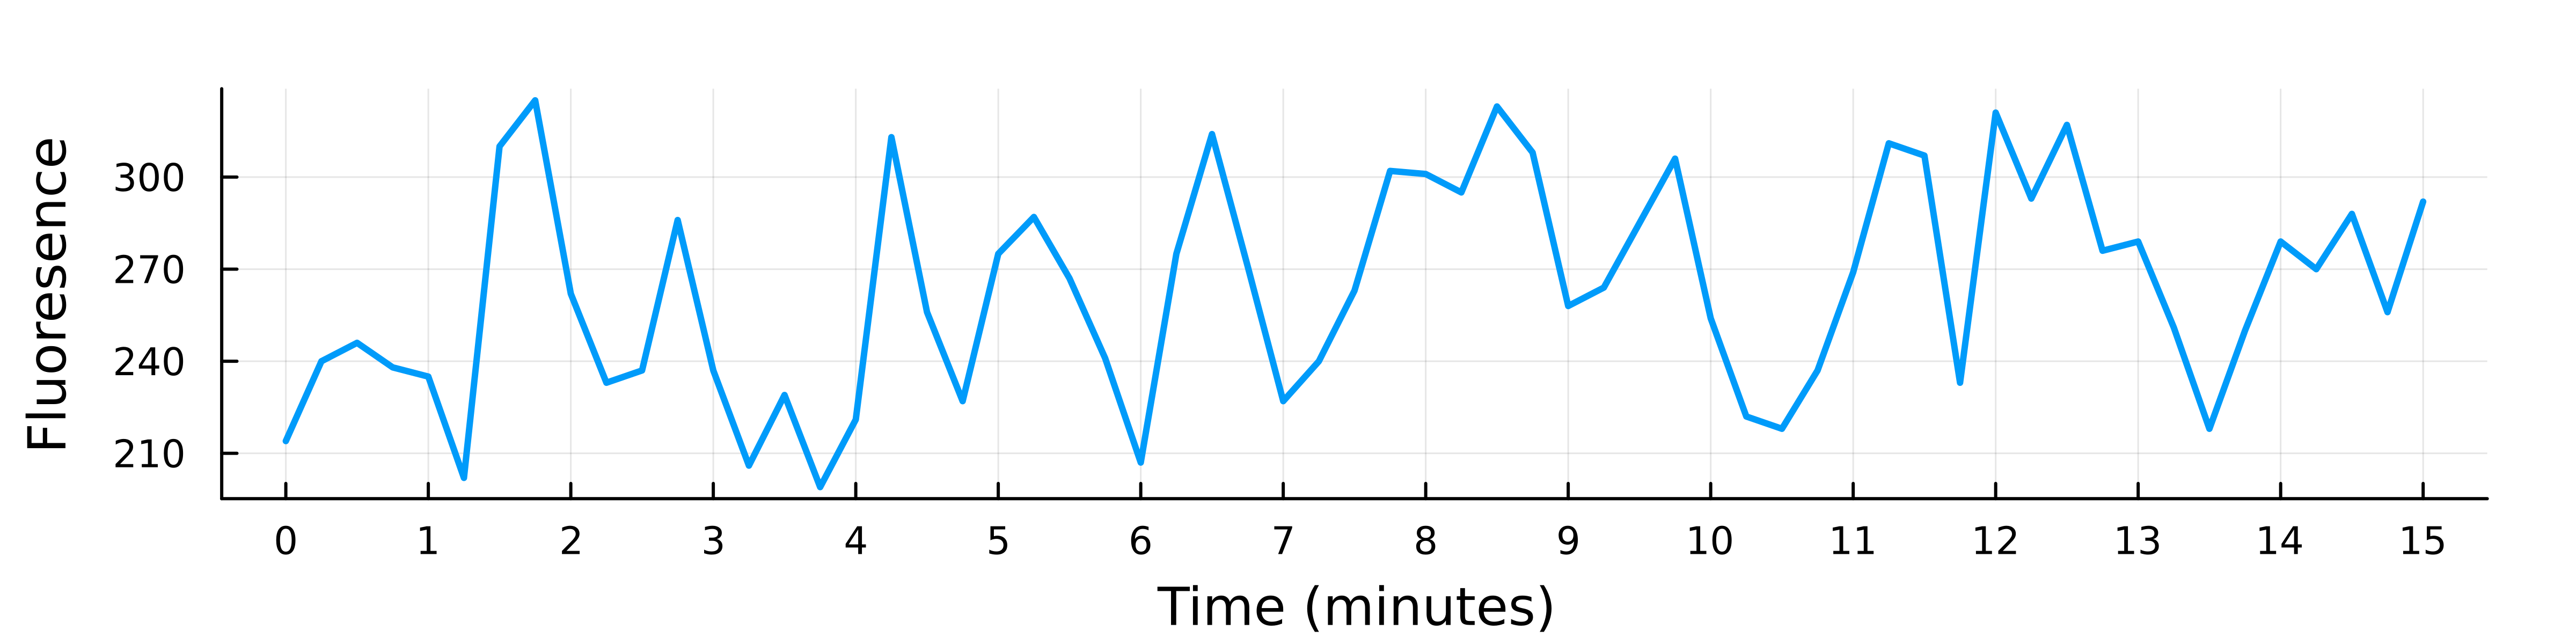

In [94]:
file = "../data/movies-rga-bem3-cdc42/bem3/cell3.tif"

interval = 15
time_threshold=0.45
masks = mask_site(file, 0.5, n_sites=1);
im_size = length(masks[:,1,1,1])*length(masks[1,:,1,1])
m1 = masks[:,:,:,1]
q1 = maximum(m1, dims=(1,2))[1,1,:]
times_max1 = crop_times(q1, 15*(60/interval), time_threshold)
crop1 = q1[times_max1]
t = range(0,60/interval*15)*(interval/60) # Convert from 1 frame every 5 sec, to minutes
plot(t, crop1, xticks=range(0,15), linewidth=2, label=false, dpi=600,
    xlabel="Time (minutes)", ylabel="Fluoresence", size=(800,200), margin=5Plots.mm)
#savefig("../figures/3XGB_1site_m3c21.png")

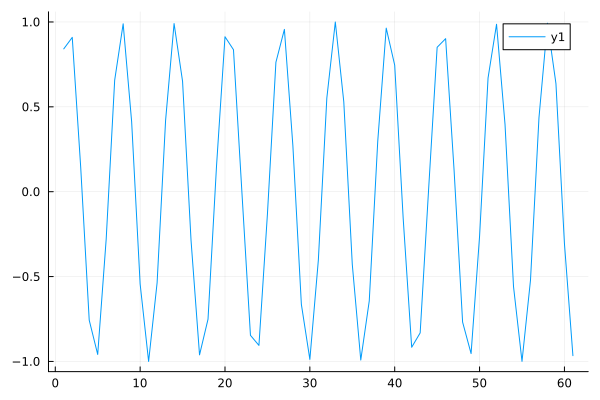

In [95]:
sig = sin.(1:length(crop1))
plot(sig)

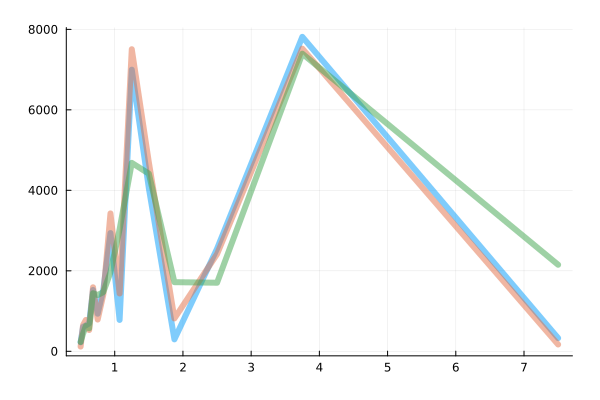

In [96]:
pdg_max = DSP.Periodograms.welch_pgram(crop1, Int(round(length(crop1)/2)), 0)
pdg_max2 = DSP.Periodograms.welch_pgram(crop1, Int(round(length(crop1)/2)), 5)
pdg_max3 = DSP.Periodograms.welch_pgram(crop1, Int(round(length(crop1)/2)), 20)
max_powers = pdg_max.power
max_powers2 = pdg_max2.power
max_powers3 = pdg_max3.power
frequencies = pdg_max.freq
plot(1 ./ frequencies[2:end] .* (15/60), max_powers[2:end], xflip = false, label=false, linewidth=6, alpha=0.5, margin=5Plots.mm)
plot!(1 ./ frequencies[2:end] .* (15/60), max_powers2[2:end], xflip = false, label=false, linewidth=6, alpha=0.5, margin=5Plots.mm)
plot!(1 ./ frequencies[2:end] .* (15/60), max_powers3[2:end], xflip = false, label=false, linewidth=6, alpha=0.5, margin=5Plots.mm)

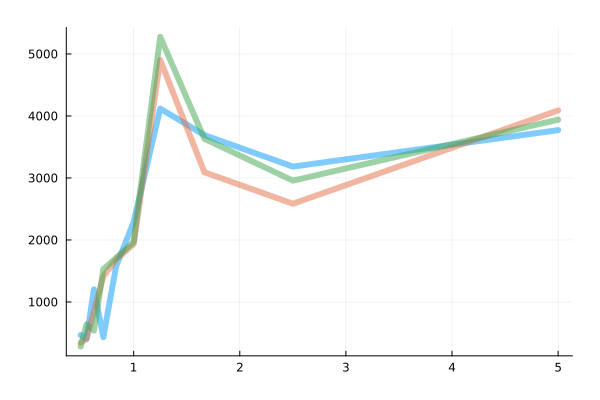

In [98]:
pdg_max = DSP.Periodograms.welch_pgram(crop1, Int(round(length(crop1)/3)), 0)
pdg_max2 = DSP.Periodograms.welch_pgram(crop1, Int(round(length(crop1)/3)))
pdg_max3 = DSP.Periodograms.welch_pgram(crop1, Int(round(length(crop1)/3)), Int(round(length(crop1)/3))-1)
max_powers = pdg_max.power
max_powers2 = pdg_max2.power
max_powers3 = pdg_max3.power
frequencies = pdg_max.freq
plot(1 ./ frequencies[2:end] .* (15/60), max_powers[2:end], xflip = false, label=false, linewidth=6, alpha=0.5, margin=5Plots.mm)
plot!(1 ./ frequencies[2:end] .* (15/60), max_powers2[2:end], xflip = false, label=false, linewidth=6, alpha=0.5, margin=5Plots.mm)
plot!(1 ./ frequencies[2:end] .* (15/60), max_powers3[2:end], xflip = false, label=false, linewidth=6, alpha=0.5, margin=5Plots.mm)